In [ ]:
# essentials
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os, sys
from scipy.stats import gamma, beta

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.computational_utilities import simultaneous_ecdf_bands

In [ ]:
sys.path.append("../src")
from networks_10092022 import DynamicGaussianNetworkJoint
from priors import diffusion_prior, random_walk_prior
from micro_models import dynamic_batch_diffusion, diffusion_trial, fast_dm_simulate
from macro_models import random_walk_shared_var, random_walk
from context import generate_design_matrix
from transformations import scale_z, unscale_z

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
N_OBS         = 3200
N_PARAMS      = 6
N_SBC         = 10
N_SAMPLES_SBC = 4

TIME_SLICES = np.array([1, 800, 1600, 2400, 3200]) - 1

In [ ]:
MACRO_MEAN  = beta(a=1, b=25).mean()
MACRO_STD   = beta(a=1, b=25).std()
MICRO_MEANS = [1.75, 1.75, 1.75, 1.75, 1.7, 1] # calculated based on 10000 simulated theta_1:3200
MICRO_STDS   = [1.5, 1.5, 1.5, 1.5, 1.25, 1] # calculated based on 10000 simulated theta_1:3200

In [ ]:
def generator_fun(batch_size, T):
    theta = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = random_walk_prior(batch_size, N_PARAMS)
    theta_t = random_walk(theta, eta, T)
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context).astype(np.float32)
    x = tf.concat((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    
    theta_t_z = theta_t.copy()
    for i in range(theta_t.shape[0]):
        theta_t_z[i] =  scale_z(theta_t[i], MICRO_MEANS,  MICRO_STDS)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x

In [ ]:
network_settings = {
    'embedding_lstm_units' : 512, 
    'embedding_gru_units': 512,
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkJoint(network_settings)

In [ ]:
network.load_weights('../trained_networks/full_dynamic_dm_3200_joint')

## SBC

In [ ]:
%%time
# generate data
eta_z, theta_t_z, data = generator_fun(N_SBC, N_OBS)
print(eta_z.shape)
print(theta_t_z.shape)
print(data.shape)

In [ ]:
pred = network(data)

In [ ]:
counter = 0
for x in tf.split(data, 2, axis=0):
    if counter == 0:
        eta_z_pred, theta_z_pred = network.sample_n(x, N_SAMPLES_SBC)
    else:
        eta_z_tmp, theta_z_tmp = network.sample_n(x, N_SAMPLES_SBC)
        eta_z_pred = np.concatenate((eta_z_pred, eta_z_tmp), axis=1)
        theta_z_pred = np.concatenate((theta_z_pred, theta_z_tmp), axis=1)
    counter += 1
    

In [ ]:
theta_pred = unscale_z(theta_z_pred, MICRO_MEANS, MICRO_STDS)
theta_sim = unscale_z(theta_t_z, MICRO_MEANS, MICRO_STDS)
theta_pred = np.transpose(theta_pred, (1, 0, 2, 3))
print(theta_pred.shape)
print(theta_sim.shape)

In [129]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

FONT_SIZE_1 = 20
FONT_SIZE_2 = 20
FONT_SIZE_3 = 18
FONT_SIZE_4 = 16

TIME_SLICES = np.array([1, 800, 1600, 2400, 3200]) - 1
PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [130]:
def plot_sbc_ecdf(post, prior, fill_color='grey', **kwargs):

    fig = plt.figure(figsize=(20, 20), constrained_layout=True)

    # create 5x1 subfigs
    subfigs = fig.subfigures(nrows=5, ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'$t = {(TIME_SLICES+1)[row]}$', fontsize=FONT_SIZE_1, fontweight='bold')

        post_samples = post[:, :, row, :]
        prior_samples = prior[:, row, :]

        # Store reference to number of parameters
        n_params = post_samples.shape[-1]
        
        # Compute fractional ranks (using broadcasting)    
        ranks = np.sum(post_samples < prior_samples[:, np.newaxis, :], axis=1) / post_samples.shape[1]

        # Compute uniform ECDF and bands
        alpha, z, L, H = simultaneous_ecdf_bands(post_samples.shape[0], **kwargs.pop('ecdf_bands_kwargs', {}))


        # create 1x6 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=6)
        for col, ax in enumerate(axs):
            ecdf_single = np.sort(ranks[:, col])
            xx = ecdf_single
            yy = np.arange(1, xx.shape[-1]+1)/float(xx.shape[-1])

            ax.plot(xx, yy, color='#852626', alpha=0.95, label='Rank ECDF', lw=2.5)
            ax.fill_between(z, L, H, color=fill_color, linewidth=0, alpha=0.3, label=f'{int((1-alpha) * 100)}% Confidence Bands')

            ax.grid(alpha=0.2)
            ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)
            sns.despine(ax=ax)

            if row == 0:
                ax.set_title(PARAM_LABELS[col] + ' ({})'.format(PARAM_NAMES[col]), fontsize=FONT_SIZE_2)
                if col == 0:
                    ax.set_xlabel('Fractional rank statistic', fontsize=FONT_SIZE_3)
                    ax.set_ylabel('ECDF', fontsize=FONT_SIZE_3)
            else:
                ax.set_title(' ', fontsize=FONT_SIZE_2)
                if col == 0:
                    ax.set_xlabel(' ', fontsize=FONT_SIZE_3)
                    ax.set_ylabel(' ', fontsize=FONT_SIZE_3)




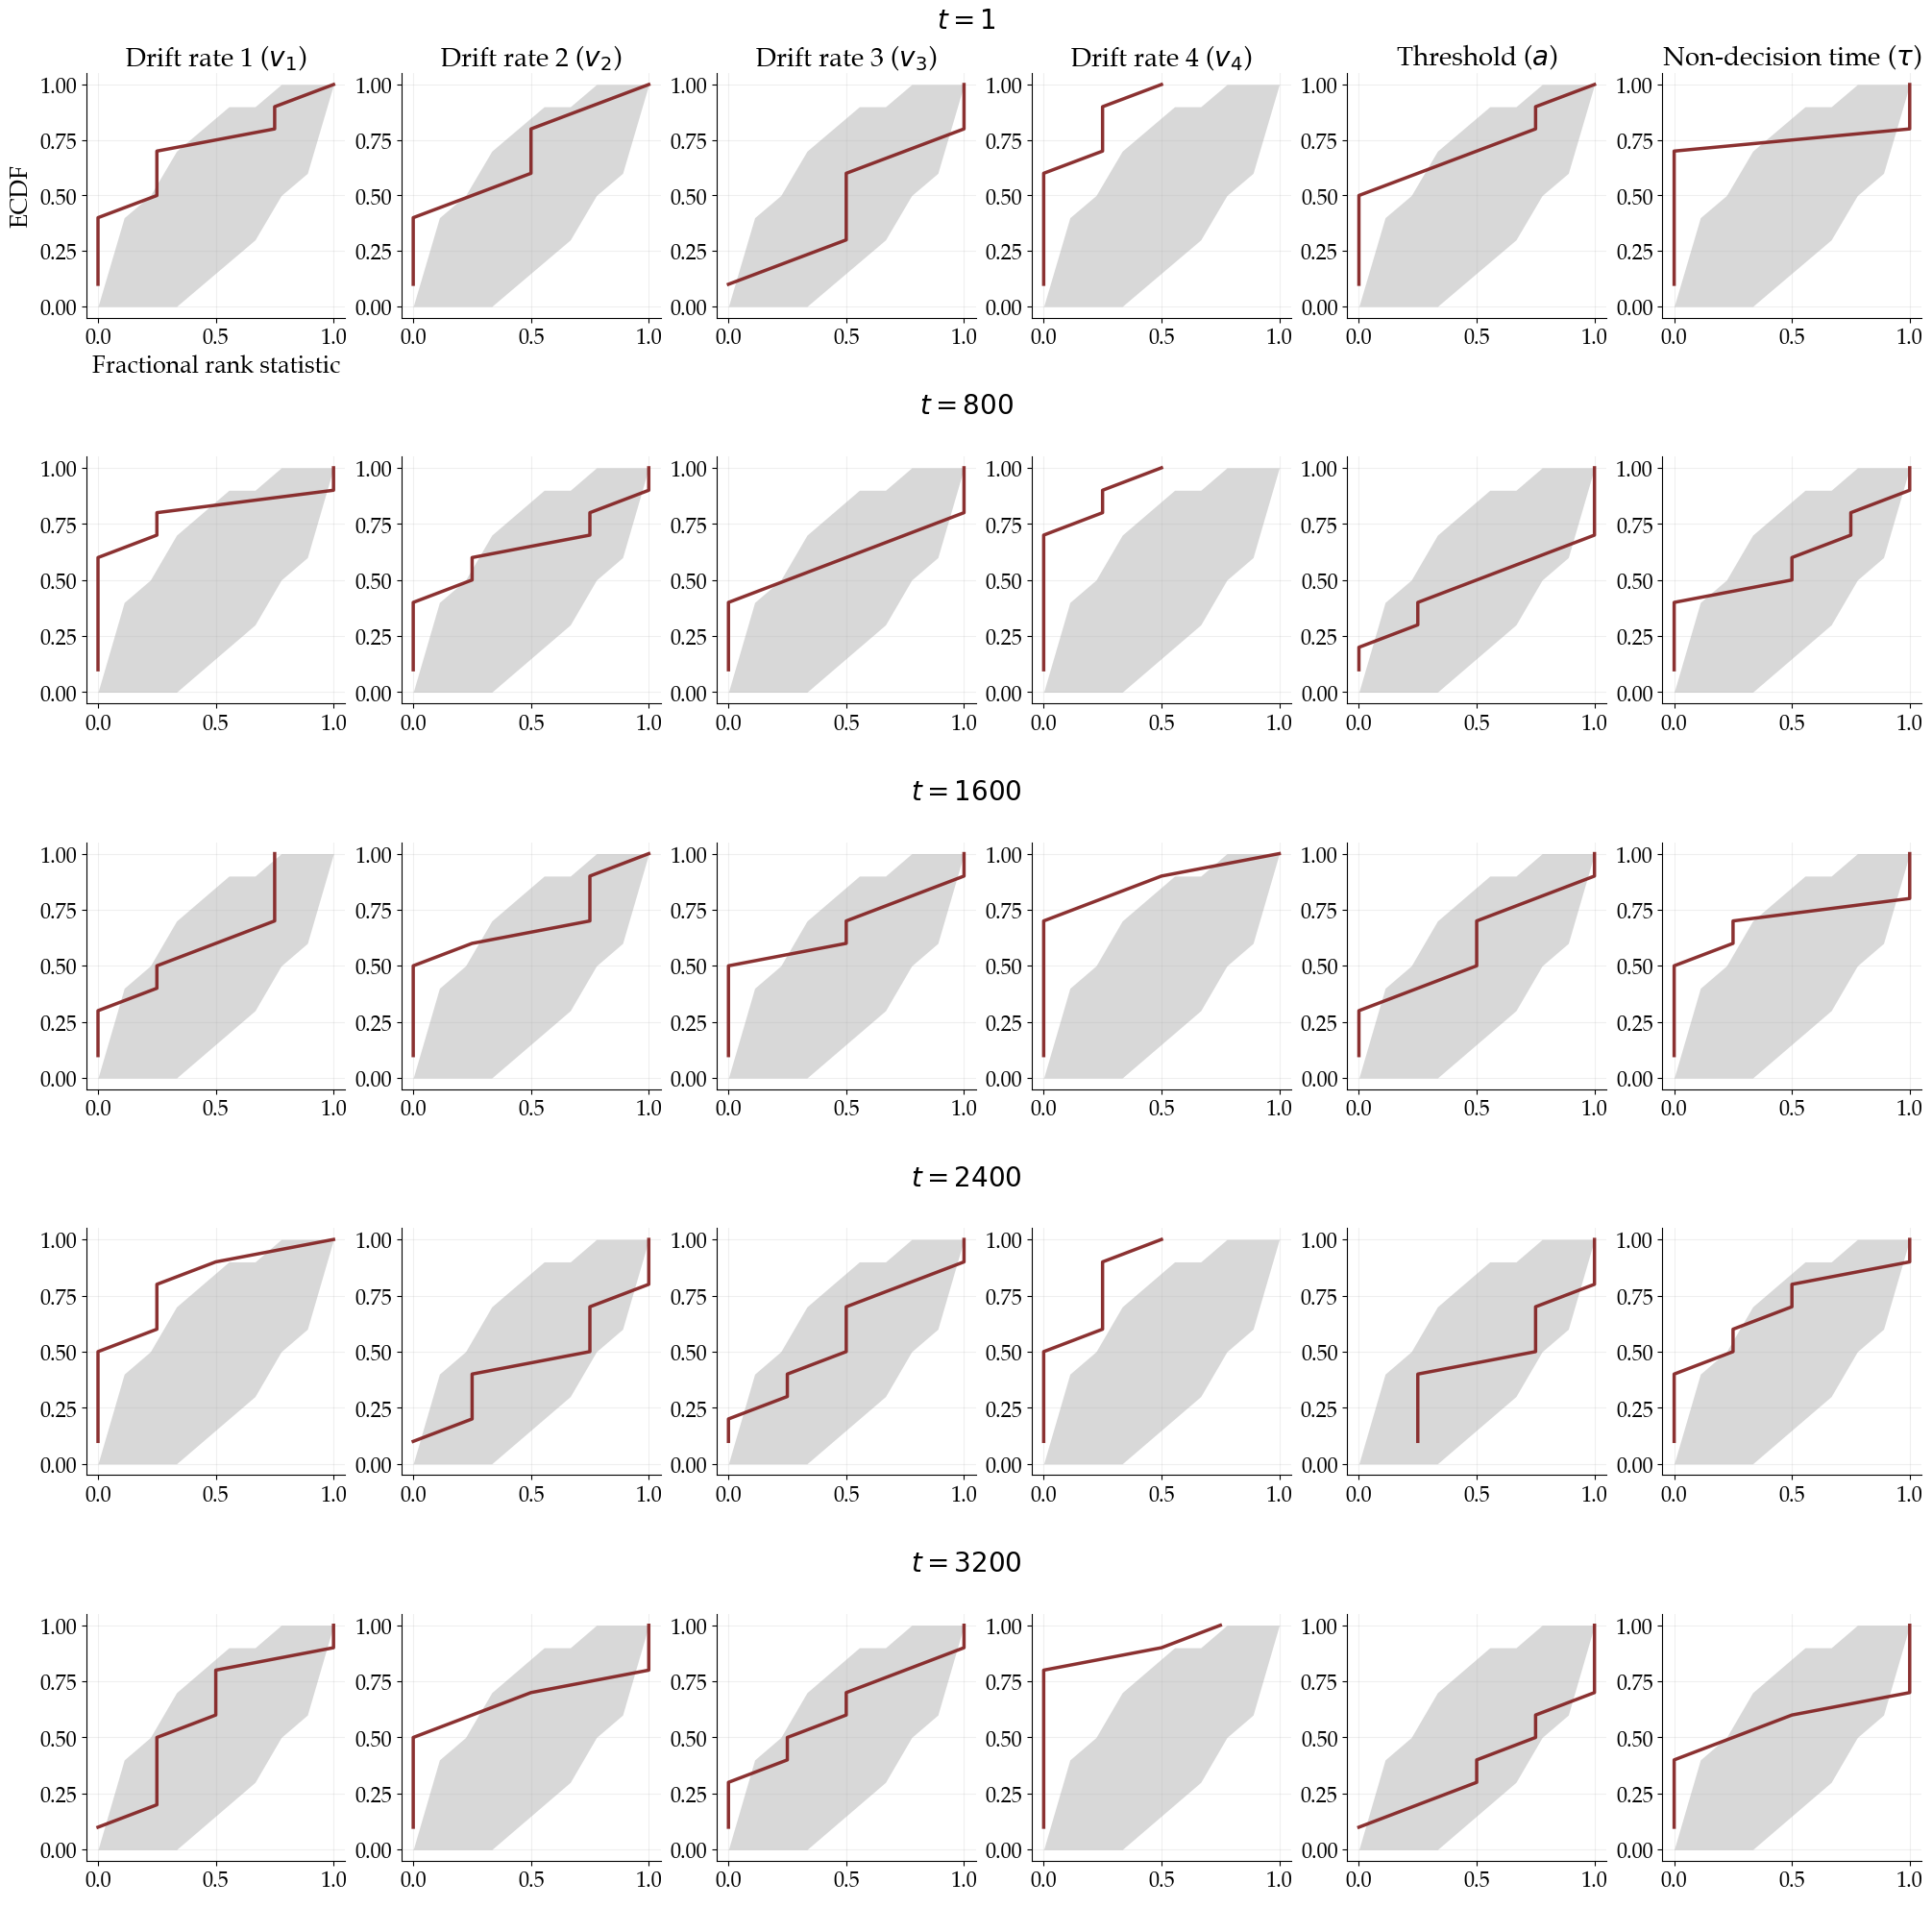

In [131]:
plot_sbc_ecdf(theta_pred, theta_sim)

In [ ]:
# make sure this is up to date